In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from keras.preprocessing.sequence import pad_sequences

import pandas as pd
import matplotlib as mpl
import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import keras.backend as K 

from keras.callbacks import EarlyStopping,ModelCheckpoint

from keras.utils import np_utils
from keras.models import Sequential, load_model

from keras.layers import BatchNormalization, Conv1D, LSTM,Input, Dense, Dropout,TimeDistributed, Flatten,MaxPooling1D
from keras.optimizers import Adam
from keras.models import Model

from keras.callbacks import ReduceLROnPlateau
from keras.applications.mobilenet import MobileNet, decode_predictions
from keras.applications.resnet50 import ResNet50, decode_predictions

from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, classification_report


import random

from collections import Counter

import ast
import os
import cv2

Using TensorFlow backend.


In [2]:
all_data = pd.read_csv("true_split_data/dataset_1.csv")

In [3]:
all_data['drawing'] = all_data['drawing'].apply(ast.literal_eval)

In [4]:
all_data.shape

(500000, 6)

In [5]:
word_lst = list(all_data['word'].unique())

In [6]:
train2, test = train_test_split(all_data, test_size=0.3, shuffle = True, 
                                random_state = 42,
                                stratify = all_data['word'])

In [7]:
train, valid=  train_test_split(train2, test_size=0.3, shuffle = True,
                                random_state= 42,
                                stratify = train2['word'])

In [8]:
train.reset_index()

,index,countrycode,drawing,key_id,recognized,timestamp,word
0,314753,DE,"[[[0, 7, 25, 38, 55, 66], [254, 255, 250, 238,...",5646107411480576,True,2017-01-26 18:43:01.380580,tree
1,492869,US,"[[[68, 50, 38, 36, 36, 39, 47, 59, 72, 84, 94,...",5473062302515200,True,2017-03-17 16:31:17.325340,rabbit
2,372319,SG,"[[[96, 132, 160, 218, 236, 246, 253, 255, 246,...",4586392325718016,True,2017-03-22 11:43:37.384300,circle
3,180635,NZ,"[[[132, 114, 100, 83, 55, 20, 10, 0, 0, 11, 24...",6648796731670528,True,2017-03-29 00:09:58.301300,baseball
4,379365,IT,"[[[24, 18, 4, 0, 3, 15, 35, 32, 50, 86, 80, 83...",5520963414261760,True,2017-01-13 13:06:44.855950,rhinoceros
...,...,...,...,...,...,...,...
244995,28270,US,"[[[16, 6, 11, 124, 173, 184, 230, 254, 252, 20...",4808730434600960,True,2017-03-21 21:09:31.561950,pillow
244996,375937,DK,"[[[2, 8, 19, 32, 32, 39, 51, 60], [115, 29, 13...",5310256806625280,True,2017-01-26 09:12:16.166870,rhinoceros
244997,300300,TH,"[[[9, 10, 30, 68, 152, 152, 139, 138, 132, 105...",4657055174492160,True,2017-03-27 13:05:53.220870,chair
244998,128207,GB,"[[[80, 76, 76, 79, 83, 24, 0, 1, 26], [0, 7, 2...",6522387375849472,True,2017-01-29 19:57:23.400480,rake


In [9]:
print(train.shape)
print(valid.shape)
print(test.shape)

(245000, 6)
(105000, 6)
(150000, 6)


In [10]:
word_le = LabelEncoder()
word_le.fit(all_data['word'])

LabelEncoder()

In [11]:
word_le.classes_

array(['The Mona Lisa', 'airplane', 'ambulance', 'backpack', 'bandage',
       'baseball', 'baseball bat', 'basketball', 'bat', 'beard', 'belt',
       'blackberry', 'bowtie', 'bracelet', 'brain', 'bridge', 'bus',
       'butterfly', 'camel', 'camouflage', 'car', 'ceiling fan', 'chair',
       'circle', 'clarinet', 'crab', 'crayon', 'dog', 'ear', 'elbow',
       'eyeglasses', 'fan', 'feather', 'flip flops', 'flower', 'garden',
       'garden hose', 'giraffe', 'goatee', 'golf club', 'grass', 'guitar',
       'hand', 'harp', 'headphones', 'hedgehog', 'hockey puck',
       'hockey stick', 'horse', 'hourglass', 'house plant', 'keyboard',
       'lantern', 'leg', 'line', 'lipstick', 'megaphone', 'microphone',
       'microwave', 'monkey', 'moon', 'mouse', 'ocean', 'paint can',
       'paintbrush', 'pear', 'peas', 'pencil', 'penguin', 'pillow',
       'power outlet', 'rabbit', 'rainbow', 'rake', 'remote control',
       'rhinoceros', 'rollerskates', 'saw', 'screwdriver', 'sea turtle',
      

### Split

In [12]:
size = 64
word_num = len(word_lst)
BASE_SIZE = 256

#### cv2.line
* img: 선분이 그려질 이미지  
* (x1,y1) 선분의 시작점
* (x2,y2) 선분의 끝점
* color: 색상(0~255)
* thickness

In [13]:
def reshape_draw(rs, size=256, lw=6):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for s in rs:
        for i in range(len(s[0]) - 1):
            cv2.line(img, (s[0][i], s[1][i]), (s[0][i + 1], s[1][i + 1]), 255, lw) 
            #c2.line(img:이미지 파일, pt1:시작점 좌표(x,y), pt2:종료점좌표(x,y), color:색상(0~255), thickness:선두께(defalut1), lineType:선종류, shift)
            
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size)) #cv2.resize(원본 이미지, 결과 이미지 크기, 보간법)
    else:
        return img

In [14]:
def drawing_make_array(df, size = size, lw = 6):
    x = np.zeros((len(df),size,size))
    for i, rs in enumerate(df.drawing.values):
        x[i] = reshape_draw(rs,size=size,lw=lw)
    x = x/255 # 정규화
    x = x.reshape((len(df),size,size,1)).astype(np.float32)
    return x

In [15]:
train_X = drawing_make_array(train, size)
train_y = to_categorical(word_le.transform(train['word'].values))

In [16]:
valid_X = drawing_make_array(valid, size)
valid_y = to_categorical(word_le.transform(valid['word'].values))

In [17]:
test_X = drawing_make_array(test, size)
test_y = to_categorical(word_le.transform(test['word'].values))

In [18]:
train_X.shape

(245000, 64, 64, 1)

In [19]:
valid_X.shape

(105000, 64, 64, 1)

In [20]:
test_X.shape

(150000, 64, 64, 1)

## Model

In [51]:
STEPS= 1000
batch = 32
epochs = 100

In [47]:
datagen = ImageDataGenerator()

In [49]:
K.clear_session()

In [40]:
base_model = ResNet50(include_top=False, input_shape=(size, size, 1), weights=None, classes=word_num)

C:\Users\julia\Desktop\tf\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [41]:
x = base_model.output
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(word_num, activation='softmax')(x)

In [42]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [43]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy])

In [44]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [52]:
check_point = ModelCheckpoint('model_1212_resnet_v1.h5', monitor='val_loss', mode='min', save_best_only=True)
reduceRP = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=12,
                          mode='min', min_lr= 0.00001, verbose=1)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15)

callbacks = [check_point, early, reduceRP]

In [53]:
hist = model.fit(train_X,train_y,
                 epochs=epochs,
                 validation_data=(valid_X, valid_y),
                 batch_size = batch,
                 callbacks = callbacks
)

Train on 245000 samples, validate on 105000 samples
Epoch 1/100
245000/245000 [==============================] - 2988s 12ms/step - loss: 4.6061 - categorical_crossentropy: 4.6060 - categorical_accuracy: 0.0099 - val_loss: 4.6054 - val_categorical_crossentropy: 4.6054 - val_categorical_accuracy: 0.0100
Epoch 2/100
245000/245000 [==============================] - 2964s 12ms/step - loss: 4.6058 - categorical_crossentropy: 4.6057 - categorical_accuracy: 0.0094 - val_loss: 4.6054 - val_categorical_crossentropy: 4.6055 - val_categorical_accuracy: 0.0100
Epoch 3/100
245000/245000 [==============================] - 2925s 12ms/step - loss: 4.6058 - categorical_crossentropy: 4.6058 - categorical_accuracy: 0.0099 - val_loss: 4.6054 - val_categorical_crossentropy: 4.6054 - val_categorical_accuracy: 0.0100
Epoch 4/100
245000/245000 [==============================] - 2916s 12ms/step - loss: 4.6058 - categorical_crossentropy: 4.6058 - categorical_accuracy: 0.0098 - val_loss: 4.6054 - val_categorical_

KeyboardInterrupt: 

In [ ]:
import winsound as ws

def beepsound():
    freq = 2000    # range : 37 ~ 32767
    dur = 1000     # ms
    ws.Beep(freq, dur) # winsound.Beep(frequency, duration)


In [ ]:
print(beepsound())

In [48]:
# hist = model.fit_generator(
#     datagen.flow(train_X,train_y,batch_size = batch),
#     steps_per_epoch = STEPS,
#     validation_steps=STEPS, epochs=epochs, verbose=1,
#     validation_data=(valid_X, valid_y),
#     callbacks = callbacks
# )

Epoch 1/100
100/100 [==============================] - 101s 1s/step - loss: 4.6052 - categorical_crossentropy: 4.6052 - categorical_accuracy: 0.0103 - val_loss: 4.6053 - val_categorical_crossentropy: 4.6053 - val_categorical_accuracy: 0.0100
Epoch 2/100
100/100 [==============================] - 105s 1s/step - loss: 4.6055 - categorical_crossentropy: 4.6055 - categorical_accuracy: 0.0100 - val_loss: 4.6053 - val_categorical_crossentropy: 4.6053 - val_categorical_accuracy: 0.0100
Epoch 3/100
100/100 [==============================] - 106s 1s/step - loss: 4.6053 - categorical_crossentropy: 4.6053 - categorical_accuracy: 0.0093 - val_loss: 4.6053 - val_categorical_crossentropy: 4.6053 - val_categorical_accuracy: 0.0100
Epoch 4/100
100/100 [==============================] - 106s 1s/step - loss: 4.6053 - categorical_crossentropy: 4.6053 - categorical_accuracy: 0.0102 - val_loss: 4.6053 - val_categorical_crossentropy: 4.6053 - val_categorical_accuracy: 0.0100
Epoch 5/100
100/100 [===========

Epoch 35/100
100/100 [==============================] - 106s 1s/step - loss: 4.6055 - categorical_crossentropy: 4.6055 - categorical_accuracy: 0.0101 - val_loss: 4.6053 - val_categorical_crossentropy: 4.6053 - val_categorical_accuracy: 0.0100
Epoch 36/100
100/100 [==============================] - 107s 1s/step - loss: 4.6057 - categorical_crossentropy: 4.6057 - categorical_accuracy: 0.0097 - val_loss: 4.6053 - val_categorical_crossentropy: 4.6053 - val_categorical_accuracy: 0.0100
Epoch 37/100
100/100 [==============================] - 106s 1s/step - loss: 4.6057 - categorical_crossentropy: 4.6057 - categorical_accuracy: 0.0091 - val_loss: 4.6052 - val_categorical_crossentropy: 4.6052 - val_categorical_accuracy: 0.0100
Epoch 38/100
100/100 [==============================] - 107s 1s/step - loss: 4.6054 - categorical_crossentropy: 4.6054 - categorical_accuracy: 0.0080 - val_loss: 4.6052 - val_categorical_crossentropy: 4.6052 - val_categorical_accuracy: 0.0100
Epoch 39/100
100/100 [======

In [51]:
hist2 = model.fit_generator(
    datagen.flow(train_X,train_y,batch_size = batch),
    steps_per_epoch = STEPS,
    validation_steps=STEPS, epochs=epochs, verbose=1,
    validation_data=(valid_X, valid_y),
    callbacks = callbacks
)

Epoch 1/100
100/100 [==============================] - 98s 978ms/step - loss: 4.6052 - categorical_crossentropy: 4.6052 - categorical_accuracy: 0.0107 - val_loss: 4.6052 - val_categorical_crossentropy: 4.6052 - val_categorical_accuracy: 0.0100
Epoch 2/100
100/100 [==============================] - 103s 1s/step - loss: 4.6053 - categorical_crossentropy: 4.6053 - categorical_accuracy: 0.0088 - val_loss: 4.6053 - val_categorical_crossentropy: 4.6052 - val_categorical_accuracy: 0.0100
Epoch 3/100
100/100 [==============================] - 104s 1s/step - loss: 4.6053 - categorical_crossentropy: 4.6053 - categorical_accuracy: 0.0097 - val_loss: 4.6053 - val_categorical_crossentropy: 4.6053 - val_categorical_accuracy: 0.0100
Epoch 4/100
100/100 [==============================] - 106s 1s/step - loss: 4.6053 - categorical_crossentropy: 4.6053 - categorical_accuracy: 0.0101 - val_loss: 4.6053 - val_categorical_crossentropy: 4.6053 - val_categorical_accuracy: 0.0100
Epoch 5/100
100/100 [=========

100/100 [==============================] - 101s 1s/step - loss: 4.6054 - categorical_crossentropy: 4.6054 - categorical_accuracy: 0.0093 - val_loss: 4.6052 - val_categorical_crossentropy: 4.6052 - val_categorical_accuracy: 0.0100
Epoch 68/100
100/100 [==============================] - 101s 1s/step - loss: 4.6053 - categorical_crossentropy: 4.6053 - categorical_accuracy: 0.0109 - val_loss: 4.6052 - val_categorical_crossentropy: 4.6052 - val_categorical_accuracy: 0.0100
Epoch 69/100
100/100 [==============================] - 101s 1s/step - loss: 4.6054 - categorical_crossentropy: 4.6054 - categorical_accuracy: 0.0098 - val_loss: 4.6052 - val_categorical_crossentropy: 4.6052 - val_categorical_accuracy: 0.0100
Epoch 70/100
100/100 [==============================] - 101s 1s/step - loss: 4.6054 - categorical_crossentropy: 4.6054 - categorical_accuracy: 0.0096 - val_loss: 4.6052 - val_categorical_crossentropy: 4.6052 - val_categorical_accuracy: 0.0100
Epoch 71/100
100/100 [===================

In [ ]:
hist3 = model.fit_generator(
    datagen.flow(train_X,train_y,batch_size = batch),
    steps_per_epoch = STEPS,
    validation_steps=STEPS, epochs=epochs, verbose=1,
    validation_data=(valid_X, valid_y),
    callbacks = callbacks
)

Epoch 1/100
100/100 [==============================] - 98s 980ms/step - loss: 4.6051 - categorical_crossentropy: 4.6051 - categorical_accuracy: 0.0095 - val_loss: 4.6052 - val_categorical_crossentropy: 4.6052 - val_categorical_accuracy: 0.0100
Epoch 2/100
100/100 [==============================] - 101s 1s/step - loss: 4.6052 - categorical_crossentropy: 4.6052 - categorical_accuracy: 0.0096 - val_loss: 4.6052 - val_categorical_crossentropy: 4.6052 - val_categorical_accuracy: 0.0100
Epoch 3/100
100/100 [==============================] - 101s 1s/step - loss: 4.6051 - categorical_crossentropy: 4.6051 - categorical_accuracy: 0.0104 - val_loss: 4.6052 - val_categorical_crossentropy: 4.6052 - val_categorical_accuracy: 0.0100
Epoch 4/100
100/100 [==============================] - 101s 1s/step - loss: 4.6051 - categorical_crossentropy: 4.6051 - categorical_accuracy: 0.0123 - val_loss: 4.6052 - val_categorical_crossentropy: 4.6052 - val_categorical_accuracy: 0.0100
Epoch 5/100
100/100 [=========

100/100 [==============================] - 102s 1s/step - loss: 4.6053 - categorical_crossentropy: 4.6053 - categorical_accuracy: 0.0102 - val_loss: 4.6052 - val_categorical_crossentropy: 4.6052 - val_categorical_accuracy: 0.0100
Epoch 68/100
100/100 [==============================] - 102s 1s/step - loss: 4.6054 - categorical_crossentropy: 4.6054 - categorical_accuracy: 0.0095 - val_loss: 4.6052 - val_categorical_crossentropy: 4.6052 - val_categorical_accuracy: 0.0100
Epoch 69/100
100/100 [==============================] - 102s 1s/step - loss: 4.6053 - categorical_crossentropy: 4.6053 - categorical_accuracy: 0.0092 - val_loss: 4.6052 - val_categorical_crossentropy: 4.6052 - val_categorical_accuracy: 0.0100
Epoch 70/100
100/100 [==============================] - 102s 1s/step - loss: 4.6053 - categorical_crossentropy: 4.6053 - categorical_accuracy: 0.0085 - val_loss: 4.6052 - val_categorical_crossentropy: 4.6052 - val_categorical_accuracy: 0.0100
Epoch 71/100
100/100 [===================

In [31]:
K.clear_session()
base_model = MobileNet(input_shape=(size, size, 1), include_top=False, weights=None, classes=word_num)

In [32]:
x = base_model.output
x = Flatten()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(word_num, activation='softmax')(x)

In [33]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [34]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy])


In [35]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 65, 65, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        288       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 32, 32, 32)        128 

In [36]:
check_point = ModelCheckpoint('model.h5', monitor='val_loss', mode='min', save_best_only=True,
                    save_weights_only=True)
reduceRP = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=10,
                          mode='min', min_lr= 0.0001, verbose=1)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15)

callbacks = [check_point, early, reduceRP]

In [37]:
hist = model.fit_generator(
    datagen.flow(train_X,train_y,batch_size = batch),
    steps_per_epoch = STEPS,
    validation_steps=STEPS, epochs=epochs, verbose=1,
    validation_data=(valid_X, valid_y),
    callbacks = callbacks
)

Epoch 1/100
100/100 [==============================] - 288s 3s/step - loss: 5.8698 - categorical_crossentropy: 5.8698 - categorical_accuracy: 0.0054 - val_loss: 5.8325 - val_categorical_crossentropy: 5.8325 - val_categorical_accuracy: 0.0029
Epoch 2/100
100/100 [==============================] - 139s 1s/step - loss: 5.6210 - categorical_crossentropy: 5.6210 - categorical_accuracy: 0.0092 - val_loss: 5.8489 - val_categorical_crossentropy: 5.8489 - val_categorical_accuracy: 0.0031
Epoch 3/100
100/100 [==============================] - 139s 1s/step - loss: 5.4970 - categorical_crossentropy: 5.4970 - categorical_accuracy: 0.0097 - val_loss: 5.8962 - val_categorical_crossentropy: 5.8962 - val_categorical_accuracy: 0.0029
Epoch 4/100
100/100 [==============================] - 140s 1s/step - loss: 5.3961 - categorical_crossentropy: 5.3961 - categorical_accuracy: 0.0130 - val_loss: 5.9486 - val_categorical_crossentropy: 5.9486 - val_categorical_accuracy: 0.0029
Epoch 5/100
100/100 [===========

Epoch 35/100
100/100 [==============================] - 152s 2s/step - loss: 4.4076 - categorical_crossentropy: 4.4076 - categorical_accuracy: 0.0791 - val_loss: 3.9329 - val_categorical_crossentropy: 3.9329 - val_categorical_accuracy: 0.1316
Epoch 36/100
100/100 [==============================] - 170s 2s/step - loss: 4.3794 - categorical_crossentropy: 4.3794 - categorical_accuracy: 0.0814 - val_loss: 3.8205 - val_categorical_crossentropy: 3.8205 - val_categorical_accuracy: 0.1467
Epoch 37/100
100/100 [==============================] - 160s 2s/step - loss: 4.3265 - categorical_crossentropy: 4.3265 - categorical_accuracy: 0.0846 - val_loss: 3.7295 - val_categorical_crossentropy: 3.7295 - val_categorical_accuracy: 0.1615
Epoch 38/100
100/100 [==============================] - 159s 2s/step - loss: 4.3011 - categorical_crossentropy: 4.3011 - categorical_accuracy: 0.0871 - val_loss: 3.6861 - val_categorical_crossentropy: 3.6861 - val_categorical_accuracy: 0.1690
Epoch 39/100
100/100 [======

Epoch 69/100
100/100 [==============================] - 145s 1s/step - loss: 2.4149 - categorical_crossentropy: 2.4149 - categorical_accuracy: 0.4115 - val_loss: 2.2052 - val_categorical_crossentropy: 2.2052 - val_categorical_accuracy: 0.4534
Epoch 70/100
100/100 [==============================] - 145s 1s/step - loss: 2.4009 - categorical_crossentropy: 2.4009 - categorical_accuracy: 0.4084 - val_loss: 2.1621 - val_categorical_crossentropy: 2.1621 - val_categorical_accuracy: 0.4566
Epoch 71/100
100/100 [==============================] - 144s 1s/step - loss: 2.3660 - categorical_crossentropy: 2.3660 - categorical_accuracy: 0.4320 - val_loss: 2.3026 - val_categorical_crossentropy: 2.3026 - val_categorical_accuracy: 0.4399
Epoch 72/100
100/100 [==============================] - 828s 8s/step - loss: 2.3314 - categorical_crossentropy: 2.3314 - categorical_accuracy: 0.4316 - val_loss: 2.3342 - val_categorical_crossentropy: 2.3342 - val_categorical_accuracy: 0.4400
Epoch 73/100
100/100 [======

In [ ]:
hist2 = model.fit_generator(
    datagen.flow(train_X,train_y,batch_size = batch),
    steps_per_epoch = STEPS,
    validation_steps=STEPS, epochs=epochs, verbose=1,
    validation_data=(valid_X, valid_y),
    callbacks = callbacks
)

Epoch 1/100
100/100 [==============================] - 185s 2s/step - loss: 1.7145 - categorical_crossentropy: 1.7145 - categorical_accuracy: 0.5666 - val_loss: 1.6497 - val_categorical_crossentropy: 1.6497 - val_categorical_accuracy: 0.5697
Epoch 2/100
 99/100 [============================>.] - ETA: 0s - loss: 1.7178 - categorical_crossentropy: 1.7178 - categorical_accuracy: 0.5570

In [38]:
hist.history.keys()

dict_keys(['val_loss', 'val_categorical_crossentropy', 'val_categorical_accuracy', 'loss', 'categorical_crossentropy', 'categorical_accuracy', 'lr'])

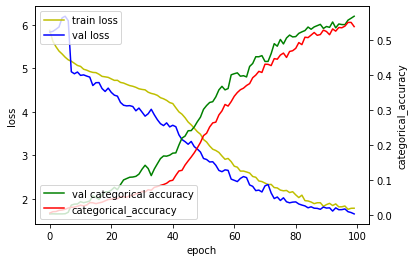

In [39]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'b', label='val loss')

acc_ax.plot(hist.history['val_categorical_accuracy'], 'g', label='val categorical accuracy')
acc_ax.plot(hist.history['categorical_accuracy'], 'r', label='categorical_accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('categorical_accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## Evaluation

In [40]:
pred_y = model.predict(test_X, batch_size= batch)

In [41]:
ppp = np.argmax(pred_y,1)

In [42]:
ttt = np.argmax(test_y,1)

In [43]:
ppp

array([115, 329,  27, ...,  50, 306, 181], dtype=int64)

In [44]:
ttt

array([115, 329, 300, ...,  50, 210, 181], dtype=int64)

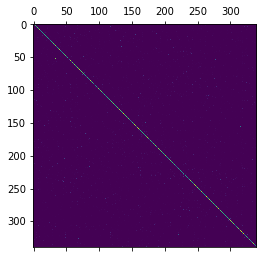

In [45]:
plt.matshow(confusion_matrix(ttt,ppp))

In [48]:
part1 = classification_report(ttt, ppp, 
                            target_names = [x for x in word_le.classes_])

* 이미지 그리기

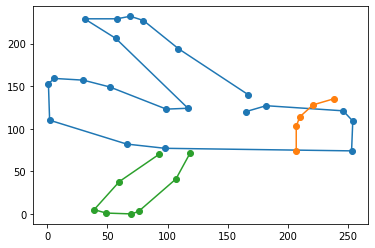

In [122]:
raw_images = list(all_data['drawing'])

k = 0
for i in range(len(raw_images[k])):
    plt.plot(raw_images[k][i][0], raw_images[k][i][1],'o-')
plt.show()

In [171]:
def get_Xy(in_df):
    X = np.stack(in_df['drawing'], 0)
    y = to_categorical(word_encoder.transform(in_df['word'].values))
    return X, y
train_X, train_y = get_Xy(train_df)
valid_X, valid_y = get_Xy(valid_df)
test_X, test_y = get_Xy(test_df)
print(train_X.shape)

NameError: name 'train_df' is not defined

In [108]:

stroke_read_model = Sequential()
stroke_read_model.add(BatchNormalization(input_shape = (None,)))
# filter count and length are taken from the script https://github.com/tensorflow/models/blob/master/tutorials/rnn/quickdraw/train_model.py
stroke_read_model.add(Conv1D(48, (5,)))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Conv1D(64, (5,)))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Conv1D(96, (3,)))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(LSTM(128, return_sequences = True))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(LSTM(128, return_sequences = False))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Dense(512))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Dense(len(word_encoder.classes_), activation = 'softmax'))
stroke_read_model.compile(optimizer = 'adam', 
                          loss = 'categorical_crossentropy', 
                          metrics = ['categorical_accuracy', top_3_accuracy])
stroke_read_model.summary()

ValueError: Axis -1 of input tensor should have a defined dimension but the layer received an input with shape (None, None).